In [270]:
include("read_nu_dist_sphere.jl")
include("read_eff_area.jl")
include("read_energy_res.jl")
include("functions_utils.jl")

# Packages

using DelimitedFiles
using StatsBase
using Interpolations
using Plots
using LaTeXStrings
using FFTW
using Distributions
using Profile
using PyCall
using SpecialFunctions
using Optim
using StaticArrays
using Healpix
using BenchmarkTools

# Importing the necessary python libraries
@pyimport matplotlib.pyplot as plt
@pyimport numpy as np
@pyimport healpy as hp

In [271]:
# Getting the simulation with the 1/r^2 weights
rs_r2, ls_r2, bs_r2, rweights_r2 = read_models("r2weighted_1", "r2weighted_2")
oneweights_r2 = Weights(ones(length(rweights_r2)))
;

In [272]:
# Getting the simulation with the 1/r weights
rs_r, ls_r, bs_r, rweights_r = read_models("rweighted_1", "rweighted_2")
oneweights_r = Weights(ones(length(rweights_r)))
;

In [264]:
# to just remove the sim weights, use fluxw = 0
# to keep the sim weights and do nothing, let simws = oneweights, fluxw = 0
function weighthist(rs, ls, bs, simws, fluxw, removed_bins=1, rbinsize=0.1, θbinsize=π/100)

    rweights = Weights(simws ./ (rs .^ fluxw))

    # We take square angular bins
    rbins, lbins, bbins = 0:rbinsize:20, -π:θbinsize:π, -π/2:θbinsize:π/2

    # Histogramming the simulation by our radial and angular bins
    nuhist = fit(Histogram, (rs, ls, bs), rweights, (rbins, lbins, bbins), closed=:left)
    nuweights = nuhist.weights

    # removing bins to see what happens... (we expect very few neutrinos within 0.1 kpc from Earth, so it's set to 1)
    if removed_bins > 0
        nuweights[1:removed_bins, :, :] .= 0
    end

    return nuweights

end

weighthist (generic function with 4 methods)

In [265]:
# sw = sim weight, nw = no weight, fw = flux weight

nuweights_r_sw = weighthist(rs_r, ls_r, bs_r, oneweights_r, 0)
nuweights_r_nw = weighthist(rs_r, ls_r, bs_r, rweights_r, 0)
nuweights_r_fw = weighthist(rs_r, ls_r, bs_r, rweights_r, 2)

nuweights_r2_sw = weighthist(rs_r2, ls_r2, bs_r2, oneweights_r2, 0)
nuweights_r2_nw = weighthist(rs_r2, ls_r2, bs_r2, rweights_r2, 0)
nuweights_r2_fw = weighthist(rs_r2, ls_r2, bs_r2, rweights_r2, 2)
;

In [143]:
function rel_r_slice(rlbarray, rslice)
    return transpose(rlbarray[rslice, :, :])
end

rel_r_slice (generic function with 1 method)

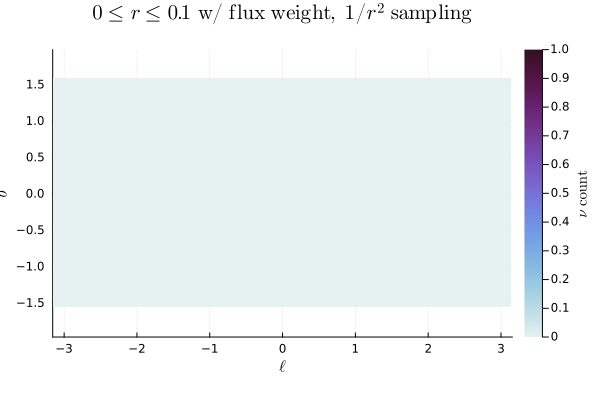

In [145]:
rbinsize, θbinsize = 0.1, π/100

rbins, lbins, bbins = 0:rbinsize:20, -π:θbinsize:π, -π/2:θbinsize:π/2

heatmap(
    range(-π, π, length(lbins)),
    range(-π/2, π/2, length(bbins)),
    rel_r_slice(nuweights_r2_fw, 1),
    title=L"0\leq r \leq 0.1\mathrm{~w/~flux~weight,~}1/r^2\mathrm{~sampling}",
    colorbar_title=L"\nu~\mathrm{count}",
    xlabel=L"\ell",
    ylabel=L"b",
    aspect_ratio=1,
    c=:dense
    )

In [146]:
nucounts_r_sw = [sum(nuweights_r_sw[i, :, :]) for i in 1:length(rbins)-1] ./ sum(nuweights_r_sw)
nucounts_r_nw = [sum(nuweights_r_nw[i, :, :]) for i in 1:length(rbins)-1] ./ sum(nuweights_r_nw)
nucounts_r_fw = [sum(nuweights_r_fw[i, :, :]) for i in 1:length(rbins)-1] ./ sum(nuweights_r_fw)

nucounts_r2_sw = [sum(nuweights_r2_sw[i, :, :]) for i in 1:length(rbins)-1] ./ sum(nuweights_r2_sw)
nucounts_r2_nw = [sum(nuweights_r2_nw[i, :, :]) for i in 1:length(rbins)-1] ./ sum(nuweights_r2_nw)
nucounts_r2_fw = [sum(nuweights_r2_fw[i, :, :]) for i in 1:length(rbins)-1] ./ sum(nuweights_r2_fw)
;

In [147]:
num_zeros_r = [count(==(0), nuweights_r_fw[i, :, :]) for i in 1:length(rbins)-1]
num_zeros_r2 = [count(==(0), nuweights_r2_fw[i, :, :]) for i in 1:length(rbins)-1]
;

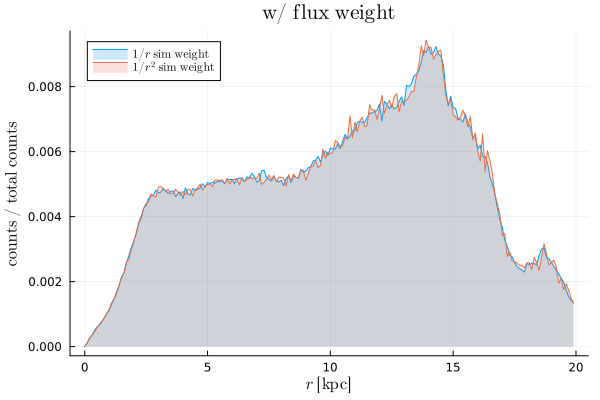

In [148]:
plot(
    rbins[1:end-1],
    [nucounts_r_nw, nucounts_r2_nw],
    title=L"\mathrm{w/~flux~weight}",
    xlabel=L"r~[\mathrm{kpc}]",
    ylabel=L"\mathrm{counts~/~total~counts}",
    label=[L"1/r~\mathrm{sim~weight}" L"1/r^2~\mathrm{sim~weight}"],
    fillrange=0,
    fillalpha=0.2
)

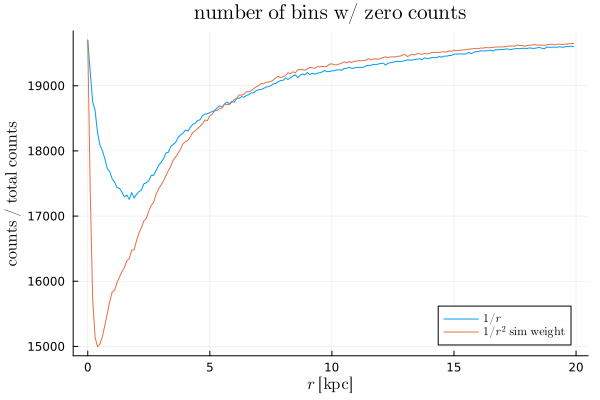

In [149]:
plot(
    rbins[1:end-1],
    [num_zeros_r num_zeros_r2],
    title=L"\mathrm{number~of~bins~w/~zero~counts}",
    xlabel=L"r~[\mathrm{kpc}]",
    ylabel=L"\mathrm{counts~/~total~counts}",
    label=[L"1/r" L"1/r^2~\mathrm{sim~weight}"],
)

In [237]:
function spatialstuff(sim_array, ilmin, ilmax, ibmin, ibmax)

    l_indices = ilmin:ilmax
    b_indices = ibmin:ibmax

    selected_elements = sim_array[:, l_indices, b_indices]

    spacedistvec = vec(sum(selected_elements, dims=(2, 3)))

end

function anglesmear_spacedist(res, sim_array)
    
    bsize = π/100

    # Healpix angle labeling scheme
    θedges = (bsize):bsize:(π-bsize)
    ϕedges = bsize:bsize:(2π-bsize)

    # Convert to galactic coordinate angle scheme
    b_range = (θedges .- π/2)
    l_range = ϕedges


    skyedistbins = [zeros(200) for _ in 1:99, _ in 1:199]
    for bi in 1:99
        for li in 1:199
            if li <= 100
                skyedistbins[bi, li] = spatialstuff(sim_array, li+99, li+99, bi, bi)
            else
                skyedistbins[bi, li] = spatialstuff(sim_array, li-100, li-100, bi, bi)
            end
        end
    end

    edistvals1 = transpose(skyedistbins)

    # Splitting the data into all-sky maps for each energy bin
    matrix = zeros(length(l_range), length(b_range))
    ebins = [copy(matrix) for _ in 1:200]
    for i in 1:200
        for j in 1:length(l_range)
            for k in 1:length(b_range)
                ebins[i][j, k] = edistvals1[j, k][i]
            end
        end
    end

    # Converting from angles to the appropriate pixels in the Healpix scheme
    nside = 128
    npix = hp.nside2npix(nside)
    theta, phi = np.meshgrid(θedges, ϕedges)
    pixel_indices = hp.ang2pix(nside, vec(theta), vec(phi)) .+ 1 # the addition is for changing indexing to Julia indexing

    # Function that converts a smoothed healpix map to a 2d array/matrix 
    function conv(map)
        mat_smoothed = zeros(npix, 3)

        for i in 1:npix
            θ, ϕ = Healpix.pix2ang(map, i) # The Julia Healpix.jl package does this a lot faster than healpy
            mat_smoothed[i, 1] = θ - π/2
            if ϕ < π
                mat_smoothed[i, 2] = ϕ
            else
                mat_smoothed[i, 2] = ϕ - 2π
            end
            mat_smoothed[i, 3] = map[i]
        end
        return mat_smoothed
    end

    # Function that does the actual angular smearing with healpy
    function smoothing(emap, i, res)

        bin = emap[i]
        e = []

        for (j, thval) in enumerate(θedges)
            for (i, phval) in enumerate(ϕedges)
                    push!(e, bin[i, j])
            end
        end

        E = np.zeros(hp.nside2npix(nside))

        E[pixel_indices] = e

        E_smoothing = hp.smoothing(E, fwhm=np.radians(res))

        # Initializing a Julia healpix map so we can use conv
        hpmap = Healpix.HealpixMap{Float64, Healpix.RingOrder}(E_smoothing)

        mat_smoothed = conv(hpmap)

        # Rebinning to match the initial sampling resolution
        bbins = (-π/2):bsize:(π/2)
        lbins = (-π):bsize:(π)
        binned = fit(Histogram, (mat_smoothed[:, 1], mat_smoothed[:, 2]), weights(mat_smoothed[:, 3]), (bbins, lbins), closed=:right)

        return binned.weights
    end

    # We return a vector with smeared skymaps for each energy bin
    smearedebins = [smoothing(ebins, i, res) for i in 1:200]

    bbins = size(smearedebins[1])[1]
    lbins = size(smearedebins[1])[2]

    allskyedists = [zeros(200) for _ in 1:bbins, _ in 1:lbins]

    for i in 1:bbins
        for j in 1:lbins
            allskyedists[i, j] = [smearedebins[k][i, j] for k in 1:200]
        end
    end

    return allskyedists

end

smearedspacedists = anglesmear_spacedist(7, nuweights_r2_fw)

function smearedspatialstuff(ilmin, ilmax, ibmin, ibmax)

    l_indices = ilmin:ilmax
    b_indices = ibmin:ibmax

    selected_elements = smearedspacedists[b_indices, l_indices]

    spacedistvec = sum(selected_elements, dims=(2, 3))
    
    float_vector = Vector{Float64}(spacedistvec[1])

end

function allskyspacedists()
    skyedistbins = [zeros(200) for _ in 1:99, _ in 1:199]
    for bi in 1:99
        for li in 1:199
            skyedistbins[bi, li] = smearedspatialstuff(li, li, bi, bi)
        end
    end
    return skyedistbins
end;

In [212]:
function oscprob(et, dm2, leff)

    # Norms squared of the PMNS matrix (exact vals might change but always needs to be unitary)
    u = @SMatrix [0.674743 0.302844 0.0224125;
                  0.0946105 0.360415 0.544974;
                  0.230646 0.33674 0.432613]

    # Conversion factor to go from kpc to 1/eV
    convfactor = 3.086e19 * 5.06773093741 * 1e6

    leff *= convfactor

    # Assuming uniform mass splitting over all three mass states
    osc = (cos((dm2 * leff)/(4*et*1e12)))^2

    prob_ee = osc*((u[1]*u[1]) + (u[4]*u[4]) + (u[7]*u[7]))
    prob_μe = osc*((u[1]*u[2]) + (u[4]*u[5]) + (u[7]*u[8]))

    prob_eτ = osc*((u[3]*u[1]) + (u[6]*u[4]) + (u[9]*u[7]))
    prob_μτ = osc*((u[3]*u[2]) + (u[6]*u[5]) + (u[9]*u[8]))

    prob_eμ = osc*((u[2]*u[1]) + (u[5]*u[4]) + (u[8]*u[7]))
    prob_μμ = osc*((u[2]*u[2]) + (u[5]*u[5]) + (u[8]*u[8]))

    prob_e = 0.333333prob_ee + 0.666666prob_μe
    prob_τ = 0.333333prob_eτ + 0.666666prob_μτ
    prob_μ = 0.333333prob_eμ + 0.666666prob_μμ

    # νμ contribution comes from the 25% chance of a neutral current interaction, which appears as a cascade
    prob_cascade = prob_e + prob_τ + 0.25prob_μ
end

function dm2stuff(dm2)
    ers = 10 .^ loges
    rbins = range(0, 20, 200)

    # effareavec = effarea.(ers) * 10000
    oscprobmat = [oscprob(er, dm2, rbin) for rbin in rbins, er in ers]

    return transpose(oscprobmat) # .* transpose(effareavec)

end

function edepflux(ers, ϕ₀, γ)
    e0 = 100.0 # TeV
    as = ϕ₀ * (ers/e0) .^ (-γ) * 3.156e-8
end;

In [236]:
# Instead store 200 length vectors and multiply by the smearing matrix later (zeros(200))
newmat = [zeros(200) for _ in 1:99, _ in 1:199]
spacedists = allskyspacedists()

# Energy ranges and getting the effective area vector
ers = 10 .^ loges
effareavec = effarea.(ers) * 10000

# Smearing matrix with effective area
energymat = erestrue * du .* transpose(effareavec)
;

In [240]:
function e_dm2_space_matrix(newmat, spacedists, dm2)

    dm2shit = dm2stuff(dm2)

    for i in 25:75
        for j in 1:199
            newmat[i, j] = dm2shit * spacedists[i, j]
        end
    end
    return newmat
end 

e_dm2_space_matrix (generic function with 1 method)

In [239]:
# Initializing some of the large matrices
bigmat_null = [zeros(200) for _ in 1:99, _ in 1:199]
bigmat_null .= e_dm2_space_matrix(newmat, spacedists, 0)
;

In [218]:
function e_dm2_space_matrix_old(newmat, spacedists, dm2)
    
    dm2shit = dm2stuff(dm2)

    bigmat = zeros(200, 200)
    # storevec = zeros(200)
    for i in 25:75
        for j in 1:199
            bigmat .= spacedists[i, j] .* dm2shit
            # storevec .= vec(sum(bigmat, dims=1))
            newmat[i, j] = transpose(energymat .* vec(sum(bigmat, dims=1)))
        end
    end
    return newmat

end;

# bigmat_null = e_dm2_space_matrix(0);

In [247]:
function smedistbinned(vec, dm2, ϕ₀, γ, flxnorm, lges=loges, δu=du)
    nbins = 25 # An admittedly arbitrary number of bins, should probably find a more intelligent number
    nsteps = 200
    vec .= vec .* δu .* (10 .^ lges) .* log(10)
    matrix = reshape(vec, (8, :)) # This 8 is the ratio nsteps/nbins
    sums = sum(matrix, dims=1) * flxnorm # This normalizing factor is to make total as null events = 748
end

unbinnedvec = zeros(200)

flxnorm = 1

function allskyedists(bigmat, unbinnedvec, energymat, dm2, ϕ₀, γ, lges=loges, fluxnorm=flxnorm)

    binnededistmat = [zeros(25) for _ in 1:99, _ in 1:199]

    ers = 10 .^ lges

    evec = edepflux(ers, ϕ₀, γ)

    for i in 1:99
        for j in 1:199
            unbinnedvec = energymat * (bigmat[i, j] .* evec)
            binnededistmat[i, j] = vec(smedistbinned(unbinnedvec, dm2, ϕ₀, γ, fluxnorm))
        end
    end

    return binnededistmat
end

asedists_null = allskyedists(bigmat_null, unbinnedvec, energymat, 0, 21.8, 2.7)
flxnorm = (748 / sum(sum(asedists_null)))
;

In [251]:
@time asedists_null = allskyedists(bigmat_null, unbinnedvec, energymat, 0, 21.8, 2.7)
;

  0.866306 seconds (236.42 k allocations: 86.736 MiB)


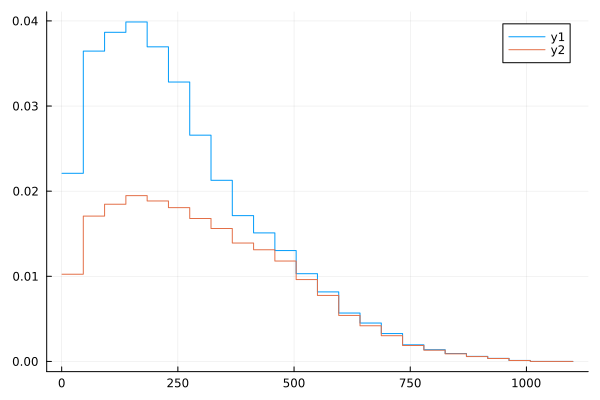

In [253]:
# Sample event dist plot from one spatial bin

plot(
    range(emin, emax, 25),
    [asedists_null[50, 150] asedists_alt[50, 150]],
    seriestype=:step
)

In [254]:
function param_optimizer(bigmat_alt, unbinnedvec, energymat, dm2)

    function negloglh(bigmat_alt, unbinnedvec, energymat, dm2, ϕ₀, γ)
        asedists_alt = allskyedists(bigmat_alt, unbinnedvec, energymat, dm2, ϕ₀, γ)

        sumllh = 0

        for i in 1:99
            for j in 1:199
                altsummand = poissonlog.(asedists_null[i, j], asedists_alt[i, j])
                sumllh += -sum(altsummand)
            end
        end
        return sumllh
    end

    function maxloglh_params(dm2)

        function nllh(test)
            return negloglh(bigmat_alt, unbinnedvec, energymat, dm2, test[1], test[2])
        end
    
        x0 = [21.8, 2.7]
    
        optimized = optimize(nllh, x0, NelderMead())

        asmaxparams = Optim.minimizer(optimized)
    
    end

    return maxloglh_params(dm2)

end

function asts(newmat, spacedists, unbinnedvec, energymat, dm2)
    bigmat_alt = e_dm2_space_matrix(newmat, spacedists, dm2)
    maxparams = param_optimizer(bigmat_alt, unbinnedvec, energymat, dm2)
    asedists_alt = allskyedists(bigmat_alt, unbinnedvec, energymat, dm2, maxparams[1], maxparams[2])
    tscontributions = [lrt(asedists_null[i, j], asedists_alt[i, j]) for i in 25:75, j in 1:199]
end;

In [256]:
@time bigmat_alt = e_dm2_space_matrix(newmat, spacedists, 10^(-13.5))

  0.145194 seconds (10.16 k allocations: 17.807 MiB)


99×199 Matrix{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  …  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]     [0.0, 0

In [257]:
@time asedists_alt = allskyedists(bigmat_alt, unbinnedvec, energymat, 10^(-13.5), 21.8, 2.7)

  1.224485 seconds (577.19 k allocations: 108.299 MiB, 48.28% compilation time)


99×199 Matrix{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  …  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]     [0.0, 0

In [36]:
@time maxparams = param_optimizer(bigmat_alt, unbinnedvec, energymat, 10^(-13.5))

 84.397608 seconds (45.51 M allocations: 10.546 GiB, 3.92% gc time, 0.04% compilation time)


2-element Vector{Float64}:
 20.09825285824758
  2.8335378018394923

In [178]:
@time ts115 = asts(newmat, spacedists, unbinnedvec, energymat, 10^(-11.5))
;

 40.551361 seconds (27.93 M allocations: 7.238 GiB, 5.56% gc time)


In [97]:
logdm2s = range(-15, -11, 41)
dm2s = 10 .^ logdm2s
tss = [asts(newmat, spacedists, unbinnedvec, energymat, dm2) for dm2 in dm2s]

41-element Vector{Matrix{Float64}}:
 [8.578069415780095e-8 1.0200411707954742e-7 … 7.623218762598786e-8 1.383545903402833e-7; 1.8718652156908475e-7 2.1737339913461888e-7 … 1.7159764074053234e-7 3.0984008383362485e-7; … ; 9.503719713392795e-7 7.277510629426999e-7 … 8.62260431610808e-7 8.121750162526974e-7; 6.578915346626747e-7 9.099765472050657e-7 … 6.512319379988373e-7 1.008540486859209e-6]
 [2.0287102400148074e-7 2.412463646340512e-7 … 1.802847975631871e-7 3.272015746380602e-7; 4.4271254573346287e-7 5.141159176389764e-7 … 4.058353925839939e-7 7.327889348550894e-7; … ; 2.2479473560527396e-6 1.7213597465564617e-6 … 2.0394984111523782e-6 1.9210493008090812e-6; 1.556178957697518e-6 2.15244156687465e-6 … 1.5404056915462133e-6 2.385594341507826e-6]
 [4.637496966390919e-7 5.514995346873854e-7 … 4.12104298108576e-7 7.47936877708212e-7; 1.0120749256490045e-6 1.1753418999792538e-6 … 9.277413807125654e-7 1.6751744405649673e-6; … ; 5.1398453192928355e-6 3.935768652160999e-6 … 4.663102863912463e-6

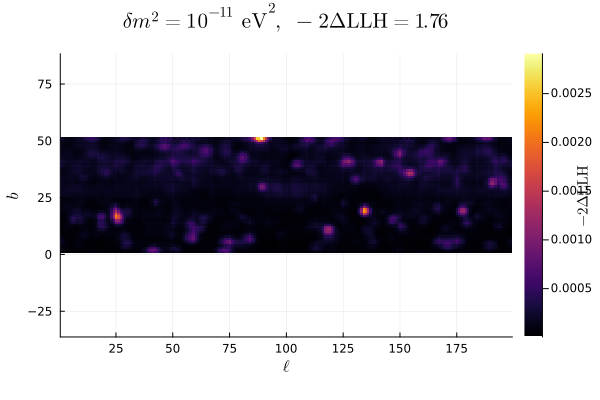

In [201]:
heatmap(tss_rem[41], aspect_ratio=1, title=L"\delta m^2 = 10^{-11}~\mathrm{eV}^2,~-2\Delta\mathrm{LLH}=1.76", xlabel=L"\ell", ylabel=L"b", colorbar_title=L"-2\Delta\mathrm{LLH}")

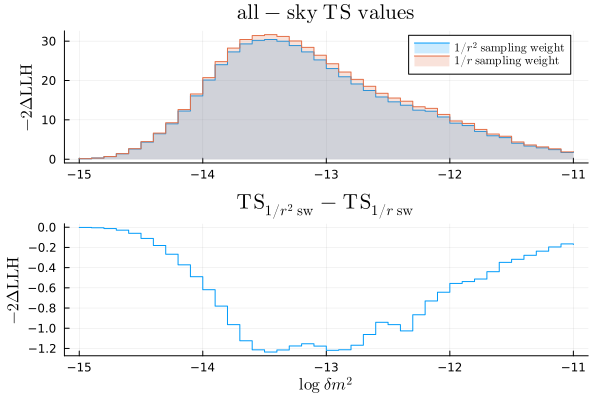

In [234]:
pcomp = plot(
    logdm2s,
    [astss_rem astss_r_rem],
    label=[L"1/r^2~\mathrm{sampling~weight}" L"1/r~\mathrm{sampling~weight}"],
    # xlabel=L"\log~\delta m^2",
    ylabel=L"-2\Delta\mathrm{LLH}",
    title=L"\mathrm{all-sky~TS~values}",
    fillrange=0,
    fillalpha=0.2,
    seriestype=:step
)

presidual = plot(
    logdm2s,
    astss_rem .- astss_r_rem,
    # label=[L"0-0.1~\mathrm{kpc~removed}" L"\mathrm{nothing~removed}"],
    label=false,
    xlabel=L"\log~\delta m^2",
    ylabel=L"-2\Delta\mathrm{LLH}",
    title=L"\mathrm{TS}_{1/r^2~\mathrm{sw}} - \mathrm{TS}_{1/r~\mathrm{sw}}",
    # fillrange=0,
    # fillalpha=0.2,
    seriestype=:step
)

plot(pcomp, presidual, layout=(2, 1))

In [260]:
#=

Animate my plots!

anim = @animate for i in 1:31
    logdm2 = logdm2s[i]
    tstot = round(tstots[i], digits=2)
    heatmap(
        range(-π, π, 199),
        range(-π/4, π/4, 51),
        testtss[i], 
        aspect_ratio = 1,
        xlabel=L"\ell",
        ylabel=L"b",
        colorbar_title=L"-2\Delta\mathrm{LLH}",
        clims=(0, mxtscont),
        title="log dm2 = $logdm2, total TS = $tstot",
        c=:greys
    )
end

gif(anim, fps=3)
=#